In [1]:
import numpy as np
from PIL import Image
import os
from model import *
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image, ImageDraw
from matplotlib.animation import FuncAnimation
from util.stroke_plotting import animate_word, plot_word_strokes

In [2]:
text_prompt = 'Magic madness heaven sin Saw you there and I thought'  # lets keep a text prompt in our repo lamao
# number of words = number of words in text_prompt
num_words = len(text_prompt.split())
print(num_words)

output_folder_path = '../../DataSet/internet/'
page_width = 300  # can be changed
img_height = 60 

10


In [3]:
# resize image to a fixed height
def resize_image(image, required_height):
    image_size = np.array(image).shape
    height, width = image_size[0], image_size[1]
    scale_factor = required_height / height
    width = int(width * scale_factor)
    resized_image = image.resize((width, required_height))
    return resized_image

In [4]:
def create_list(output_folder_path):
    width_list = []
    image_list = []
    for files in os.listdir(output_folder_path):
        if files.endswith(".png"):
            image_path = output_folder_path + files
            image = Image.open(image_path)
            image = image.convert('L')
            image_size = np.array(image).shape
            if image_size[0]!=img_height:
                image = resize_image(image, img_height)
            image = np.array(image)
            image_size = np.array(image).shape
            height, width = image_size[0], image_size[1]
            # store width of each image in a list
            width_list.append(width)
            # store image in a list
            image_list.append(image)
    return width_list, image_list

In [5]:
def forward_pass(model, image_list, width_list, space_bn_words):
    for i in range(len(image_list)):
        image = image_list[i]
        width = width_list[i]
        # convert image to tensor
        image = transforms.ToTensor()(image)
        image = image.unsqueeze(0)
        # run forward pass
        output = model(image)
        # convert output to numpy array
        output = output.detach().numpy()
        np.save('output_stroke_'+str(i)+'.npy', output)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def translate_strokes(strokes, page_width, width_list, space_bn_words):
    lines = []
    line = []

    current_width = 0
    max_x_stroke = 0
    line_height = 57  # initial line height
    for stroke, width in zip(strokes, width_list):
        if current_width + width + space_bn_words > page_width:
            # move to next line
            lines.append(np.concatenate(line, axis=0))
            max_x_stroke = 0  # reset max_x_stroke to 0
            current_width = 0  # reset current_width to 0
            line_height += 60  # increase line height
            line = []

        # add to current line
        # translate it to max_x_stroke of previous word + space_bn_words
        stroke[:, 0] += max_x_stroke + space_bn_words
        # translate y coordinate to line_height
        stroke[:, 1] += line_height - np.max(stroke[:, 1])
        line.append(stroke)
        current_width += width + space_bn_words
        max_x_stroke += width + space_bn_words

    # add the last line
    if line:
        lines.append(np.concatenate(line, axis=0))
    lines = np.concatenate(lines, axis=0)
    # animate_word(lines, speed=0.2, save_path='animation1.gif')

    return lines

In [7]:
def plot_stroke(stroke_array):
    for i in range(len(stroke_array)):
        strokes = stroke_array[i]
        for stroke in strokes:
            plt.plot(stroke[:, 0], stroke[:, 1])
        plt.show()

In [8]:
output_folder_path = '../../DataSet/IAM-Online/test_str_model/Images/'
width_list, image_list = create_list(output_folder_path)
stroke_path = '../../DataSet/IAM-Online/test_str_model/Strokes/'
stroke_array = []
for strokes in os.listdir(stroke_path):
    if strokes.endswith(".npy"):
        strokes = np.load(stroke_path + strokes)
        stroke_array.append(strokes)
        print(strokes.shape)
        
# animate_word(np.concatenate(stroke_array[0:3], axis=0), save_path='animation3.gif')
lines = translate_strokes(stroke_array, 600, width_list, space_bn_words=30)
animate_word(lines, speed=0.2, save_path='animation4.gif')

(145, 5)
(341, 5)
(83, 5)
(164, 5)
(222, 5)
(111, 5)
(140, 5)
(58, 5)
(434, 5)


IndexError: invalid index to scalar variable.

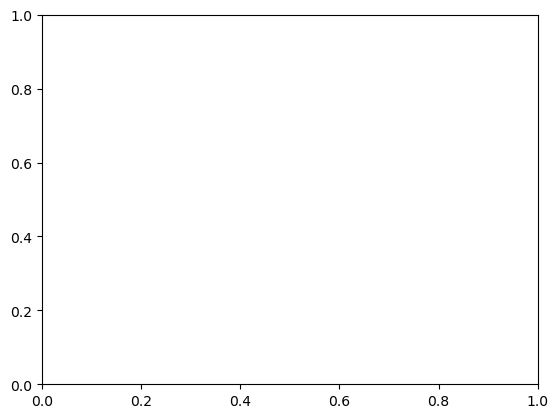

In [9]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate_lines(lines, color='black', title='', speed=0.5, save_path=None):
    ''' Animate the strokes of a word.'''
    fig, ax = plt.subplots()    
    padding = 10
    all_strokes = [stroke for line in lines for stroke in line]
    xlim = (min(stroke[:, 0].min() for stroke in all_strokes)-padding, max(stroke[:, 0].max() for stroke in all_strokes)+padding)
    ylim = (min(stroke[:, 1].min() for stroke in all_strokes)-padding//2, max(stroke[:, 1].max() for stroke in all_strokes)+padding//2)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.invert_yaxis()
    ax.axis('off')
    ax.set_aspect('equal')
    
    lines = [ax.plot([], [], color=color)[0] for _ in all_strokes]  # Create a line for each stroke
    pen, = ax.plot([], [], color='red', marker='o')  # Create a marker for the pen
    
    def animate(i):
        stroke_num = 0
        total_length = 0
        for stroke in all_strokes:
            if total_length <= i < total_length + len(stroke):
                lines[stroke_num].set_data(stroke[:i-total_length+1, 0], stroke[:i-total_length+1, 1])  # Update the line data for the current stroke
                pen.set_data(stroke[i-total_length, 0], stroke[i-total_length, 1])  # Move the pen to the current coordinate
            total_length += len(stroke)
            stroke_num += 1
        return lines + [pen]
    
    ani = animation.FuncAnimation(fig, animate, frames=sum(len(stroke) for stroke in all_strokes), interval=100/speed, blit=True)
    if save_path is not None:
        ani.save(save_path, writer='imagemagick')
    plt.show()

animate_lines(lines, color='black', title='', speed=0.5, save_path='animation.gif')